<a href="https://colab.research.google.com/github/ipeirotis/datasets/blob/master/notebooks/ERCOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

http://www.ercot.com/gridinfo/load

The archives are also there:
http://www.ercot.com/gridinfo/load/load_hist

There is a difference between the archives and real time, as I have learned :) The real time is based on telemetry substation data, whereas the historical is based on final values. This usually accounts for about a 1% difference, mostly white noise. It would be a good exercise for students to both correct this historical bias and also build timeseries forecasting models on this live data feed. ERCOT also publishes their own load forecasts, so you can use that as a good baseline for any model.

In [1]:
!sudo apt-get install unzip
!pip install -U pip
!pip install -U statsmodels xlrd PyMySQL sqlalchemy sql_magic

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-25ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use(['seaborn-talk', 'seaborn-ticks', 'seaborn-whitegrid'])

<ipython-input-3-efbe495f07cd>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use(['seaborn-talk', 'seaborn-ticks', 'seaborn-whitegrid'])
<ipython-input-3-efbe495f07cd>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use(['seaborn-talk', 'seaborn-ticks', 'seaborn-whitegrid'])
<ipython-input-3-efbe495f07cd>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain av

In [4]:
import pandas as pd
import numpy as np

In [5]:
import datetime as dt

def str_to_datetime(date_str):
    if date_str.endswith("24:00"):
        return pd.to_datetime(date_str[:10], format="%m/%d/%Y") + dt.timedelta(days=1)
    else:
        return pd.to_datetime(date_str, format="%m/%d/%Y %H:%M")

### 2023

In [6]:
!curl "https://www.ercot.com/files/docs/2023/02/09/Native_Load_2023.zip" -o native_load_2023.zip
!unzip -o native_load_2023.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  443k  100  443k    0     0  2311k      0 --:--:-- --:--:-- --:--:-- 2335k
Archive:  native_load_2023.zip
  inflating: Native_Load_2023.xlsx   


In [7]:
df2023 = pd.read_excel("Native_Load_2023.xlsx")

In [8]:
df2023.dtypes

Hour Ending     object
COAST          float64
EAST           float64
FWEST          float64
NORTH          float64
NCENT          float64
SOUTH          float64
SCENT          float64
WEST           float64
ERCOT          float64
dtype: object

In [9]:
df2023["Hour Ending"] = df2023["Hour Ending"].astype(str)

In [10]:
import re
for g in df2023["Hour Ending"].values:
  try:
    if not re.match(r"^\d\d/\d\d/\d\d\d\d \d\d:\d\d$",g):
        print(g)
  except:
    print(f"_{g}_")

In [11]:
df2023['date'] = df2023["Hour Ending"].astype(str).apply(str_to_datetime)
df2023.drop('Hour Ending', inplace=True, axis='columns')
df2023.set_index('date', inplace=True)

df2023.sort_index(inplace=True)

In [12]:
df2023

,COAST,EAST,FWEST,NORTH,NCENT,SOUTH,SCENT,WEST,ERCOT
date,,,,,,,,,
2023-01-01 01:00:00,8514.637876,1218.506271,5073.526557,917.394049,9896.757586,2859.017922,6012.400469,1116.933155,35609.173887
2023-01-01 02:00:00,8345.632899,1179.885576,5016.774637,906.854582,9675.869720,2845.779210,5934.084260,1107.417972,35012.298856
2023-01-01 03:00:00,8125.706879,1151.144653,5016.303220,894.817013,9490.332365,2734.163642,5855.790279,1101.324245,34369.582295
2023-01-01 04:00:00,7995.083655,1153.306928,5038.003823,891.733538,9420.890470,2555.339795,5840.914307,1105.457821,34000.730337
2023-01-01 05:00:00,7906.920393,1168.779618,4994.502755,896.893843,9430.780728,2484.777679,5873.683697,1108.739956,33865.078669
...,...,...,...,...,...,...,...,...,...
2023-05-31 20:00:00,16830.963445,2173.074464,5757.713701,1430.314138,18926.254677,5160.743439,10820.919849,1471.589427,62571.573139
2023-05-31 21:00:00,16249.277372,2061.613777,5712.504436,1357.031324,18042.293868,4963.232330,10363.331700,1412.062420,60161.347225
2023-05-31 22:00:00,15690.099605,1953.621682,5696.530667,1305.911891,17295.147115,4810.546445,9939.491289,1384.384586,58075.733278


### 2022

In [13]:
!curl "https://www.ercot.com/files/docs/2022/02/08/Native_Load_2022.zip" -o native_load_2022.zip
!unzip -o native_load_2022.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1067k  100 1067k    0     0  5234k      0 --:--:-- --:--:-- --:--:-- 5209k
Archive:  native_load_2022.zip
  inflating: Native_Load_2022.xlsx   


In [14]:
df2022 = pd.read_excel("Native_Load_2022.xlsx")

In [15]:
df2022.dtypes

Hour Ending     object
COAST          float64
EAST           float64
FWEST          float64
NORTH          float64
NCENT          float64
SOUTH          float64
SCENT          float64
WEST           float64
ERCOT          float64
dtype: object

In [16]:
df2022.head()

,Hour Ending,COAST,EAST,FWEST,NORTH,NCENT,SOUTH,SCENT,WEST,ERCOT
0,01/01/2022 01:00,12054.939199,1302.296674,4161.193625,757.843076,9676.300802,3172.878316,5908.031505,973.455700,38006.938896
1,01/01/2022 02:00,11793.290315,1259.355201,4147.907009,737.236591,9307.126712,3123.318608,5708.512022,959.775908,37036.522365
2,01/01/2022 03:00,11460.841252,1210.287905,4156.412366,725.610502,8920.424552,3003.396233,5463.522829,941.112359,35881.607998
3,01/01/2022 04:00,11244.980243,1179.311517,4149.811722,717.420214,8678.807826,2898.097471,5255.252404,920.373708,35044.055105
4,01/01/2022 05:00,11073.085585,1171.841803,4140.619028,719.178247,8573.370608,2825.100402,5164.172158,918.203309,34585.571140


In [17]:
df2022["Hour Ending"] = df2022["Hour Ending"].astype(str)

In [18]:
import re
for g in df2022["Hour Ending"].values:
  try:
    if not re.match(r"^\d\d/\d\d/\d\d\d\d \d\d:\d\d$",g):
        print(g)
  except:
    print(f"_{g}_")

11/06/2022 02:00 DST
2022-12-01 01:00:00


In [19]:
df2022["Hour Ending"].replace("11/06/2022 02:00 DST", "11/06/2022 02:00", inplace=True)

In [20]:
df2022["Hour Ending"].replace("2022-12-01 01:00:00", "12/01/2022 01:00", inplace=True)

In [21]:
df2022['date'] = df2022["Hour Ending"].astype(str).apply(str_to_datetime)
df2022.drop('Hour Ending', inplace=True, axis='columns')
df2022.set_index('date', inplace=True)

df2022.sort_index(inplace=True)

### 2021

In [22]:
!curl "https://www.ercot.com/files/docs/2021/11/12/Native_Load_2021.zip" -o native_load_2021.zip
!unzip -o native_load_2021.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1068k  100 1068k    0     0  3143k      0 --:--:-- --:--:-- --:--:-- 3143k
Archive:  native_load_2021.zip
  inflating: Native_Load_2021.xlsx   


In [23]:
df2021 = pd.read_excel("Native_Load_2021.xlsx")

In [24]:
df2021.dtypes

Hour Ending     object
COAST          float64
EAST           float64
FWEST          float64
NORTH          float64
NCENT          float64
SOUTH          float64
SCENT          float64
WEST           float64
ERCOT          float64
dtype: object

In [25]:
import re
for g in df2021["Hour Ending"].values:
    if not re.match(r"^\d\d/\d\d/\d\d\d\d \d\d:\d\d$",g):
        print(g)

11/07/2021 02:00 DST


In [26]:
df2021["Hour Ending"].replace("11/07/2021 02:00 DST", "11/07/2021 02:00", inplace=True)

In [27]:
df2021['date'] = df2021["Hour Ending"].apply(str_to_datetime)
df2021.drop('Hour Ending', inplace=True, axis='columns')
df2021.set_index('date', inplace=True)

df2021.sort_index(inplace=True)

### 2020

In [28]:
!curl "https://www.ercot.com/files/docs/2021/01/12/Native_Load_2020.zip" -o native_load_2020.zip
!unzip -o native_load_2020.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1074k  100 1074k    0     0  3315k      0 --:--:-- --:--:-- --:--:-- 3305k
Archive:  native_load_2020.zip
  inflating: Native_Load_2020.xlsx   


In [29]:
df2020 = pd.read_excel("Native_Load_2020.xlsx")
df2020

,HourEnding,COAST,EAST,FWEST,NORTH,NCENT,SOUTH,SCENT,WEST,ERCOT
0,01/01/2020 01:00,9890.091522,1364.278198,3721.972022,773.878822,11719.863767,2707.841517,5473.246071,1172.943179,36824.115099
1,01/01/2020 02:00,9751.586415,1369.569694,3735.514034,775.063743,11639.455987,2706.844837,5387.380467,1165.951313,36531.366488
2,01/01/2020 03:00,9603.421087,1373.528720,3735.851866,774.153775,11515.421981,2650.378864,5270.331958,1149.076769,36072.165020
3,01/01/2020 04:00,9501.585599,1365.630426,3743.517881,778.097301,11518.359020,2586.709109,5200.960612,1141.301918,35836.161867
4,01/01/2020 05:00,9499.426925,1385.600323,3753.898979,784.077729,11649.293449,2548.852381,5230.298774,1147.094161,35998.542722
...,...,...,...,...,...,...,...,...,...,...
8779,12/31/2020 20:00,12068.071946,1788.474092,3979.115067,1005.372994,16508.360213,3718.100777,8640.867717,1640.840548,49349.203353
8780,12/31/2020 21:00,11818.903690,1726.770658,3962.905180,969.428095,15752.272222,3637.379800,8505.529827,1607.467424,47980.656897
8781,12/31/2020 22:00,11560.408167,1680.800823,3925.708218,928.517370,15179.536570,3571.725609,8334.601541,1573.542580,46754.840878
8782,12/31/2020 23:00,11339.877692,1627.080961,3895.376959,891.856675,14650.060694,3524.972799,8024.802495,1521.383987,45475.412261


In [30]:
df2020["HourEnding"].replace("11/01/2020 02:00 DST", "11/01/2020 02:00", inplace=True)
df2020['date'] = df2020["HourEnding"].apply(str_to_datetime)
df2020.drop('HourEnding', inplace=True, axis='columns')
df2020.set_index('date', inplace=True)

df2020.sort_index(inplace=True)

### 2019

In [31]:
!curl "https://www.ercot.com/files/docs/2020/01/09/Native_Load_2019.zip" -o native_load_2019.zip
!unzip -o native_load_2019.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1067k  100 1067k    0     0  3717k      0 --:--:-- --:--:-- --:--:-- 3704k
Archive:  native_load_2019.zip
  inflating: Native_Load_2019.xlsx   


In [32]:
df2019 = pd.read_excel("Native_Load_2019.xlsx")



In [33]:
import re
for g in df2019["HourEnding"].values:
    if not re.match(r"^\d\d/\d\d/\d\d\d\d \d\d:\d\d$",g):
        print(g)

11/03/2019 02:00 DST


In [34]:
df2019["HourEnding"].replace("11/03/2019 02:00 DST", "11/03/2019 02:00", inplace=True)

In [35]:
len(df2019)

8760

In [36]:
df2019['date'] = df2019["HourEnding"].apply(str_to_datetime)
df2019.drop('HourEnding', inplace=True, axis='columns')
df2019.set_index('date', inplace=True)

df2019.sort_index(inplace=True)

### 2018

In [37]:
!curl "https://www.ercot.com/files/docs/2019/01/07/native_load_2018.zip" -o native_load_2018.zip
!unzip -o native_load_2018.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1067k  100 1067k    0     0  4321k      0 --:--:-- --:--:-- --:--:-- 4321k
Archive:  native_load_2018.zip
  inflating: Native_Load_2018.xlsx   


In [38]:
df2018 = pd.read_excel("Native_Load_2018.xlsx")


In [39]:
import re
for g in df2018["HourEnding"].values:
    if not re.match(r"^\d\d/\d\d/\d\d\d\d \d\d:\d\d$",g):
        print(g)

11/04/2018 02:00 DST


In [40]:
df2018["HourEnding"].replace("11/04/2018 02:00 DST", "11/04/2018 02:00", inplace=True)

In [41]:

df2018['date'] = df2018["HourEnding"].apply(str_to_datetime)
df2018.drop('HourEnding', inplace=True, axis='columns')
df2018.set_index('date', inplace=True)

### 2017

In [42]:
!curl "https://www.ercot.com/files/docs/2018/01/09/native_load_2017.zip" -o native_load_2017.zip
!unzip -o native_load_2017.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1093k  100 1093k    0     0  2382k      0 --:--:-- --:--:-- --:--:-- 2382k
Archive:  native_load_2017.zip
  inflating: native_Load_2017.xlsx   


In [43]:
df2017 = pd.read_excel("native_Load_2017.xlsx")

In [44]:
import re
for g in df2017["Hour Ending"].values:
    if not re.match(r"^\d\d/\d\d/\d\d\d\d \d\d:\d\d$",g):
        print(g)

11/05/2017 02:00 DST


In [45]:
df2017["Hour Ending"].replace("11/05/2017 02:00 DST", "11/05/2017 02:00", inplace=True)

In [46]:
df2017['date'] = df2017["Hour Ending"].apply(str_to_datetime)
df2017.drop('Hour Ending', inplace=True, axis='columns')
df2017.set_index('date', inplace=True)

In [47]:
len(df2017)/24

365.0

### 2016

In [48]:
!curl "https://www.ercot.com/files/docs/2017/01/10/native_Load_2016.zip" -o native_load_2016.zip
!unzip -o native_load_2016.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1095k  100 1095k    0     0  4584k      0 --:--:-- --:--:-- --:--:-- 4584k
Archive:  native_load_2016.zip
  inflating: native_Load_2016.xlsx   


In [49]:
df2016 = pd.read_excel("native_Load_2016.xlsx")

In [50]:
df2016.dtypes

Hour_End    datetime64[ns]
COAST              float64
EAST               float64
FAR_WEST           float64
NORTH              float64
NORTH_C            float64
SOUTHERN           float64
SOUTH_C            float64
WEST               float64
ERCOT              float64
dtype: object

In [51]:
df2016.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)

In [52]:
df2016.set_index('date', inplace=True)

In [53]:
df2016 = df2016.fillna(method="ffill")

In [54]:
len(df2016)/24

366.0

### 2015

In [55]:
!curl "https://www.ercot.com/files/docs/2016/01/07/native_load_2015.xls" -o native_load_2015.xls


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1757k  100 1757k    0     0  5458k      0 --:--:-- --:--:-- --:--:-- 5458k


In [56]:
df2015 = pd.read_excel("native_load_2015.xls")

In [57]:
df2015.head(3)

,Hour_End,COAST,EAST,FAR_WEST,NORTH,NORTH_C,SOUTHERN,SOUTH_C,WEST,ERCOT
0,2015-01-01 01:00:00.003,9844.200268,1350.784678,2078.060021,901.770195,13640.024978,3607.904503,6731.301663,1470.814721,39624.861027
1,2015-01-01 01:59:59.997,9653.456269,1333.434943,2057.993265,890.150373,13425.121941,3609.619438,6602.935629,1440.832944,39013.544802
2,2015-01-01 03:00:00.000,9502.299659,1323.908498,2039.019542,880.926639,13286.070909,3573.158363,6530.663273,1430.495044,38566.541927


In [58]:
df2015.dtypes

Hour_End    datetime64[ns]
COAST              float64
EAST               float64
FAR_WEST           float64
NORTH              float64
NORTH_C            float64
SOUTHERN           float64
SOUTH_C            float64
WEST               float64
ERCOT              float64
dtype: object

In [59]:
df2015.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)

In [60]:
df2015.set_index('date', inplace=True)

In [61]:
len(df2015)/24

365.0

### 2014

In [62]:
!curl "https://www.ercot.com/files/docs/2015/10/22/2014_ercot_hourly_load_data.xls" -o native_load_2014.xls


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1757k  100 1757k    0     0  7292k      0 --:--:-- --:--:-- --:--:-- 7262k


In [63]:
df2014 = pd.read_excel("native_load_2014.xls")

In [64]:
df2014.head(3)

,Hour_End,COAST,EAST,FAR_WEST,NORTH,NORTH_C,SOUTHERN,SOUTH_C,WEST,ERCOT
0,2014-01-01 01:00:00.003,9101.691219,1338.197939,1820.206244,793.458458,12298.801147,3236.109065,6121.146143,1102.523505,35812.133719
1,2014-01-01 01:59:59.997,8907.975782,1328.940064,1809.180861,791.141630,12297.109823,3246.493375,6091.018850,1098.774771,35570.635156
2,2014-01-01 03:00:00.000,8738.460973,1317.990846,1804.524573,789.791906,12285.295247,3217.721388,6060.017515,1097.716762,35311.519210


In [65]:
df2014.dtypes

Hour_End    datetime64[ns]
COAST              float64
EAST               float64
FAR_WEST           float64
NORTH              float64
NORTH_C            float64
SOUTHERN           float64
SOUTH_C            float64
WEST               float64
ERCOT              float64
dtype: object

In [66]:
df2014.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)

In [67]:
df2014.set_index('date', inplace=True)

In [68]:
len(df2014)/24

365.0

### 2013

In [69]:
!curl "https://www.ercot.com/files/docs/2015/10/22/2013_ercot_hourly_load_data.xls" -o native_load_2013.xls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1757k  100 1757k    0     0  3132k      0 --:--:-- --:--:-- --:--:-- 3127k


In [70]:
df2013 = pd.read_excel("native_load_2013.xls")

In [71]:
df2013.head(3)

,Hour_End,COAST,EAST,FAR_WEST,NORTH,NORTH_C,SOUTHERN,SOUTH_C,WEST,ERCOT
0,2013-01-01 01:00:00.003,7607.189871,1074.024285,1411.823159,763.069242,10370.322921,2206.945802,4368.528687,883.029500,28684.933467
1,2013-01-01 01:59:59.997,7389.267519,1035.189180,1403.601093,754.425986,10153.942806,2160.082197,4233.635250,872.532258,28002.676290
2,2013-01-01 03:00:00.000,7179.748411,1036.216739,1395.131213,746.215515,9989.243532,2065.369913,4082.897707,868.951334,27363.774363


In [72]:
df2013.dtypes

Hour_End    datetime64[ns]
COAST              float64
EAST               float64
FAR_WEST           float64
NORTH              float64
NORTH_C            float64
SOUTHERN           float64
SOUTH_C            float64
WEST               float64
ERCOT              float64
dtype: object

In [73]:
df2013.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)

In [74]:
df2013.set_index('date', inplace=True)

In [75]:
len(df2013)/24

365.0

### 2012

In [76]:
!curl "https://www.ercot.com/files/docs/2015/10/22/2012_ercot_hourly_load_data.xls" -o native_load_2012.xls
df2012 = pd.read_excel("native_load_2012.xls")
df2012.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)
df2012.set_index('date', inplace=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1762k  100 1762k    0     0  3789k      0 --:--:-- --:--:-- --:--:-- 3781k


In [77]:
len(df2012)/24

366.0

### 2011



In [78]:
!curl "https://www.ercot.com/files/docs/2015/10/22/2011_ercot_hourly_load_data.xls" -o native_load_2011.xls
df2011 = pd.read_excel("native_load_2011.xls")
df2011.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)
df2011.set_index('date', inplace=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1757k  100 1757k    0     0  7708k      0 --:--:-- --:--:-- --:--:-- 7708k


In [79]:
len(df2011)/24

365.0

### 2010

In [80]:
!curl "https://www.ercot.com/files/docs/2015/10/22/2010_ercot_hourly_load_data.xls" -o native_load_2010.xls
df2010 = pd.read_excel("native_load_2010.xls")
df2010.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)
df2010.set_index('date', inplace=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1757k  100 1757k    0     0  7353k      0 --:--:-- --:--:-- --:--:-- 7353k


In [81]:
len(df2010)/24

365.0

### 2009

In [82]:
!curl "https://www.ercot.com/files/docs/2015/10/22/2009_ercot_hourly_load_data.xls" -o native_load_2009.xls
df2009 = pd.read_excel("native_load_2009.xls")
df2009.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)
df2009.set_index('date', inplace=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1757k  100 1757k    0     0  9603k      0 --:--:-- --:--:-- --:--:-- 9603k


In [83]:
len(df2009)/24

365.0

### 2008

In [84]:
!curl "https://www.ercot.com/files/docs/2015/10/22/2008_ercot_hourly_load_data.xls" -o native_load_2008.xls
df2008 = pd.read_excel("native_load_2008.xls")
df2008.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)
df2008.set_index('date', inplace=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1762k  100 1762k    0     0  7728k      0 --:--:-- --:--:-- --:--:-- 7728k


In [85]:
len(df2008)/24

366.0

### 2007

In [86]:
!curl "https://www.ercot.com/files/docs/2015/10/22/2007_ercot_hourly_load_data.xls" -o native_load_2007.xls
df2007 = pd.read_excel("native_load_2007.xls")
df2007.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)
df2007.set_index('date', inplace=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1757k  100 1757k    0     0  5858k      0 --:--:-- --:--:-- --:--:-- 5858k


### 2006

In [87]:
!curl "https://www.ercot.com/files/docs/2015/10/22/2006_ercot_hourly_load_data.xls" -o native_load_2006.xls
df2006 = pd.read_excel("native_load_2006.xls")
df2006.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)
df2006.set_index('date', inplace=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1757k  100 1757k    0     0  9551k      0 --:--:-- --:--:-- --:--:-- 9551k


In [88]:
!curl "https://www.ercot.com/files/docs/2015/10/22/2005_ercot_hourly_load_data.xls" -o native_load_2005.xls
df2005 = pd.read_excel("native_load_2005.xls")
df2005.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)
df2005.set_index('date', inplace=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1757k  100 1757k    0     0  7322k      0 --:--:-- --:--:-- --:--:-- 7292k


In [89]:


!curl "https://www.ercot.com/files/docs/2015/10/22/2004_ercot_hourly_load_data.xls" -o native_load_2004.xls
df2004 = pd.read_excel("native_load_2004.xls")
df2004.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)
df2004.set_index('date', inplace=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1762k  100 1762k    0     0  8157k      0 --:--:-- --:--:-- --:--:-- 8157k


In [90]:


!curl "https://www.ercot.com/files/docs/2015/10/22/2003_ercot_hourly_load_data.xls" -o native_load_2003.xls
df2003 = pd.read_excel("native_load_2003.xls")
df2003.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)
df2003.set_index('date', inplace=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1757k  100 1757k    0     0  7608k      0 --:--:-- --:--:-- --:--:-- 7608k


In [91]:


!curl "https://www.ercot.com/files/docs/2015/10/22/2002_ercot_hourly_load_data.xls" -o native_load_2002.xls
df2002 = pd.read_excel("native_load_2002.xls")
df2002.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)
df2002.set_index('date', inplace=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1757k  100 1757k    0     0  6509k      0 --:--:-- --:--:-- --:--:-- 6509k


In [92]:


!curl "https://www.ercot.com/files/docs/2015/10/22/2002_ercot_hourly_load_data.xls" -o native_load_2002.xls
df2002 = pd.read_excel("native_load_2002.xls")
df2002.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)
df2002.set_index('date', inplace=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1757k  100 1757k    0     0  13.8M      0 --:--:-- --:--:-- --:--:-- 13.8M


### Concatenate

In [93]:
load_data = [df2023, df2022, df2021, df2020, df2019, df2018, df2017, df2016, df2015,
             df2014, df2013, df2012, df2011, df2010, df2009, df2008,
             df2007, df2006, df2005, df2004, df2003, df2002]

df = pd.concat(load_data, axis='index').sort_index()

<Axes: xlabel='date'>

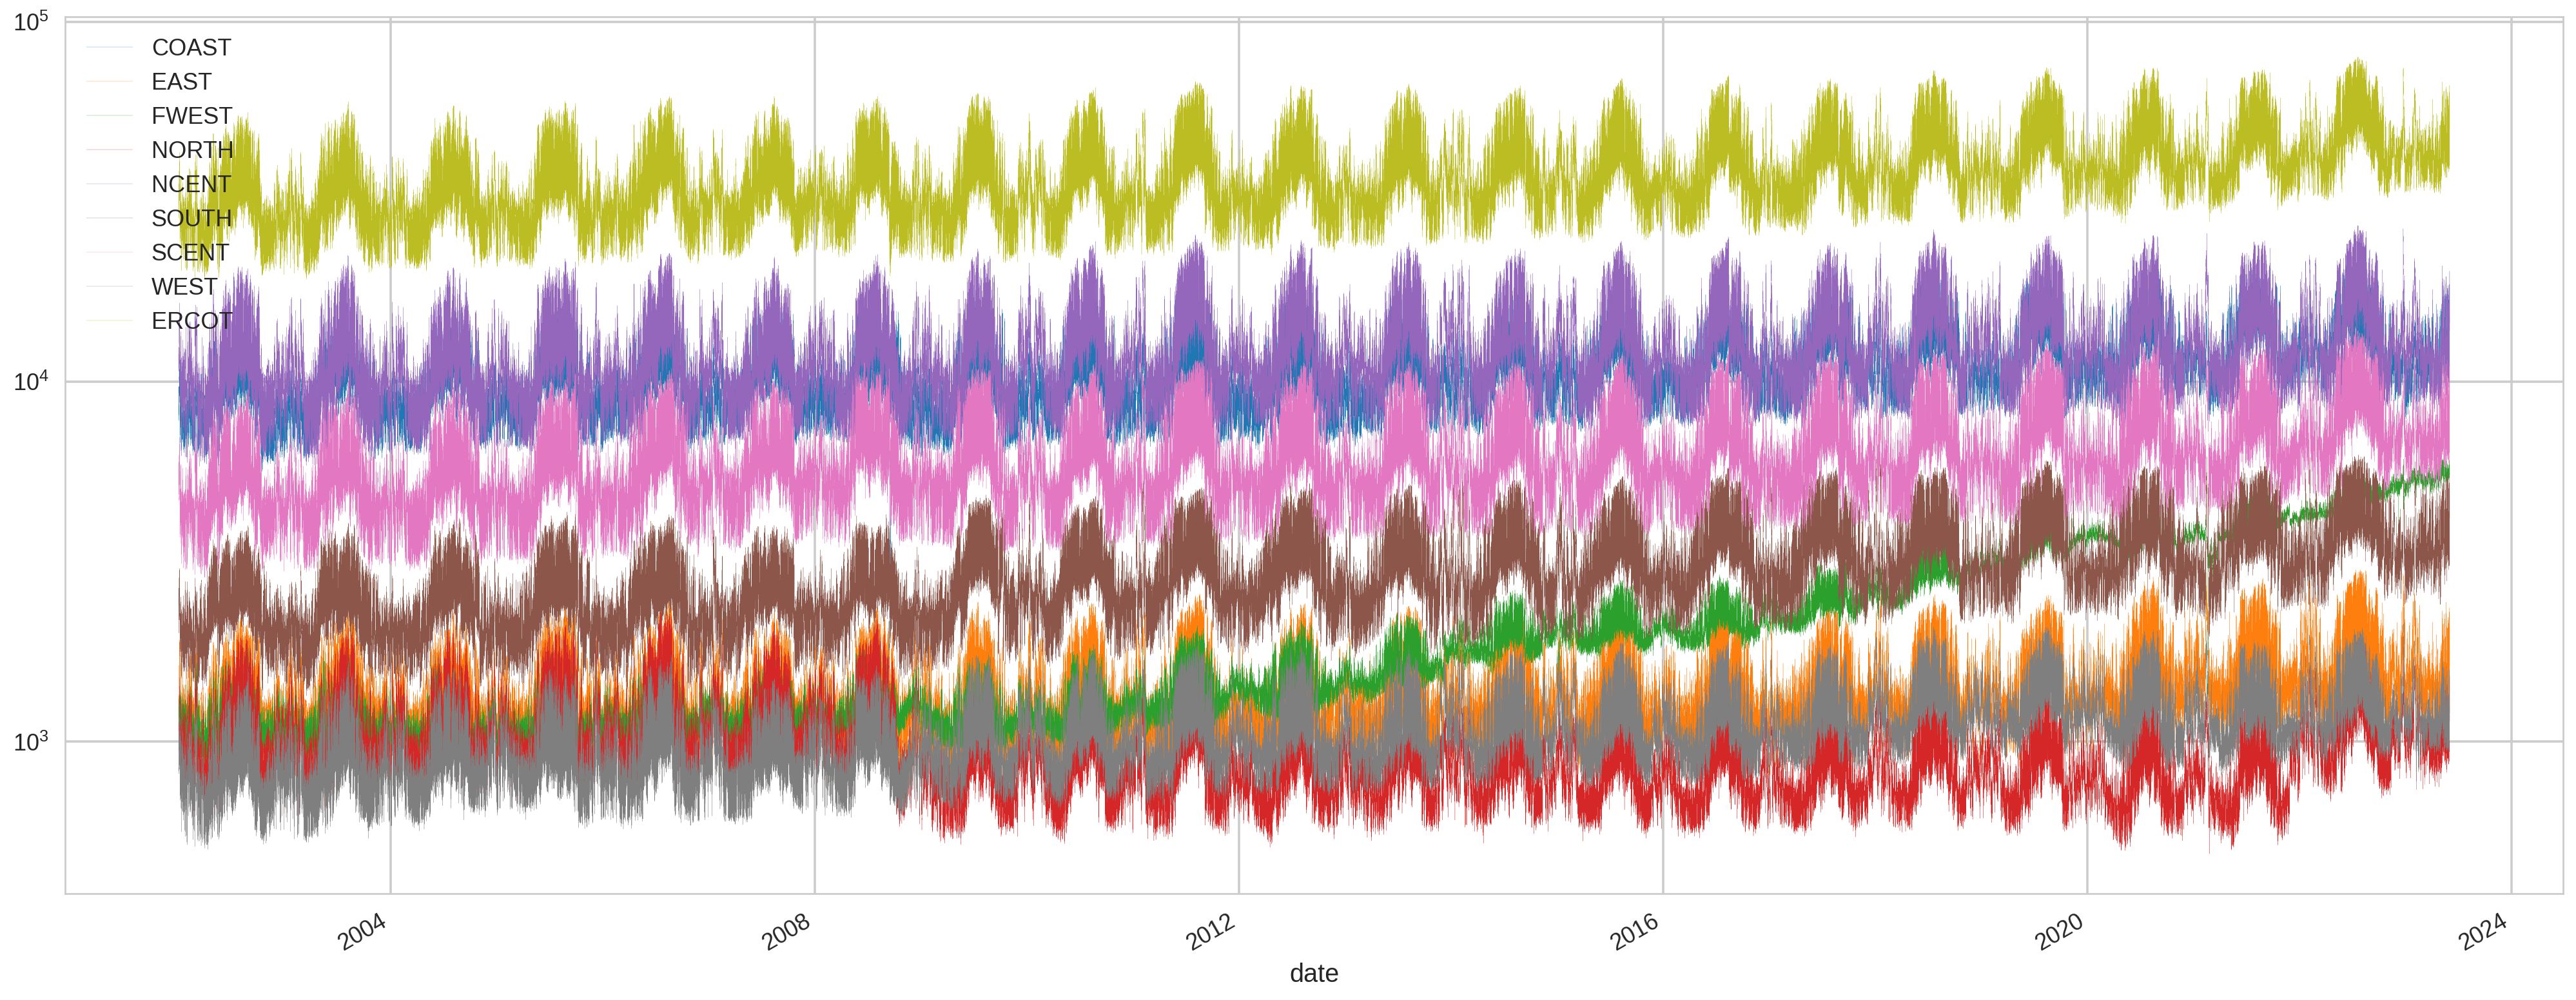

In [94]:
df.plot(figsize=(25,10), linewidth=0.1, logy=True)

In [95]:
len(df)

187703

# mySQL

In [96]:
import os
from sqlalchemy import create_engine
from sqlalchemy import text

conn_string = 'mysql+pymysql://{user}:{password}@{host}/?charset=utf8mb4'.format(
    host = 'db.ipeirotis.org',
    user = 'root',
    password = 'ae6jQniBS5muV27', #os.environ['MYSQL_PASSWORD'],
    encoding = 'utf8mb4')

engine = create_engine(conn_string)


In [97]:
# Query to create a database
db_name = 'ercot'

sql = f"DROP DATABASE IF EXISTS {db_name}"
with engine.connect() as con:
  con.execute(text(sql))

# Create a database
sql = f"CREATE DATABASE IF NOT EXISTS {db_name} DEFAULT CHARACTER SET 'utf8mb4'"
with engine.connect() as con:
  con.execute(text(sql))

# And lets switch to the database
sql = f"USE {db_name}"
with engine.connect() as con:
  con.execute(text(sql))

In [98]:
sql = '''
CREATE TABLE electricity (
  DATE_TIME datetime,
  COAST    float,
  EAST     float,
  FWEST    float,
  NORTH    float,
  NCENT    float,
  SOUTH    float,
  SCENT    float,
  WEST     float,
  ERCOT    float,
  PRIMARY KEY(DATE_TIME)
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
'''
with engine.connect() as con:
  con.execute(text(sql))

In [99]:
df.reset_index().rename({"date": "DATE_TIME"}, axis=1).to_sql(
        name = 'electricity',
        schema = db_name,
        con = engine,
        if_exists = 'replace',
        index = False,
        chunksize = 1000)

187703

In [100]:
sql = f'''
GRANT SELECT ON {db_name}.* TO 'student'@'%'
'''
with engine.connect() as con:
  con.execute(text(sql))